The filter function reads
$$
F_i(f)=\sum_j\left|R_{ij}(f)\right|^2,
$$
where we have defined the tensor
$$
R_{ij}(f) = \int_0^{t_f}dt \operatorname{Tr}[U_c^\dagger(t)\sigma_iU_c(t)\sigma_j]\,e^{i2\pi f t},
$$
and $U_c(t)$ is the unitary time evolution in absence of any noise. The infidelity is then given by
$$
1 - \mathcal{F}\propto \sum_i \int df S_i(f) F_i(f),
$$
with $S_i(f)$ the noise spectral density.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from HQUAD_lib.parallel_utils import parameter_run
from HQUAD_lib.QUAD_utils import solve_LZ
from HQUAD_lib.filter_functions import compute_FF_LZ
from HQUAD_lib.plotting_utils import plot_gradient_lines

In [2]:
x = 1
z0 = 10 * x
tf = x * np.pi / 2 * 33
tails_factor = 5
omegas = np.logspace(-2, 2, 500)

alphas = np.linspace(-5, 5, 41) * 2
alphas[0] = -np.inf
alphas[-1] = np.inf
betas = np.zeros_like(alphas)

n_plus = (alphas + betas) / 2

In [3]:
def compute_FF(alpha: float, beta: float) -> np.ndarray:
    pulse = solve_LZ(alpha, beta, x=x)

    boundary_left = np.ones(len(pulse) // tails_factor) * z0
    boundary_right = np.ones(len(pulse) // tails_factor) * (-z0)
    pulse = np.concatenate((boundary_left, pulse, boundary_right))

    return compute_FF_LZ(x, pulse, tf * (1 + 2 / tails_factor), omegas)

In [4]:
FF = parameter_run(compute_FF, 'alpha', alphas, beta=0)

compute_FF: [['alpha']]:   0%|          | 0/41 [00:00<?, ?it/s]

/Users/david/Library/CloudStorage/OneDrive-UAM/Projects/hyper-QUAD/codes/notebooks_to_share/../HQUAD_lib/plotting_utils.py:125: UserWarning: Overwriting the cmap 'shiftedcmap' that was already in the registry.
  colormaps.register(cmap=newcmap, force=True)


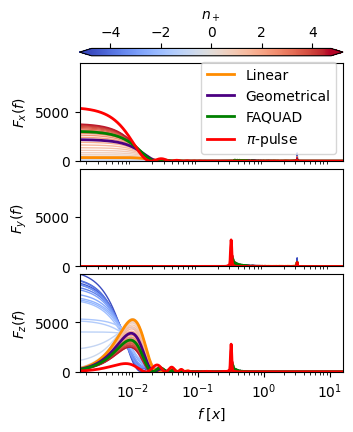

In [5]:
fig, axs = plt.subplots(4, figsize=(3.4, 4.2), gridspec_kw=dict(height_ratios=[0.075, 1, 1, 1]))

letters = ['x', 'y', 'z']
for i in range(3):
    ax = axs[i + 1]
    ax, sm = plot_gradient_lines(omegas / (2 * np.pi), FF[:, i], alphas, betas, ax=ax,
                                 y_label=rf'$F_{letters[i]}(f)$', cursor=False, legend_bool=(i == 0),
                                 cbar_bool=False)

    ax.set_xscale('log')
    ax.set_ylim(0, np.max(FF))

    if i != 2:
        ax.set_xticks([])

axs[1].legend(frameon=True)

plt.colorbar(sm, cax=axs[0], label=r'$n_+ $', orientation='horizontal', location='top', extend='both')

axs[-1].set_xlabel(r'$f\; [x]$')

fig.subplots_adjust(hspace=0.1)

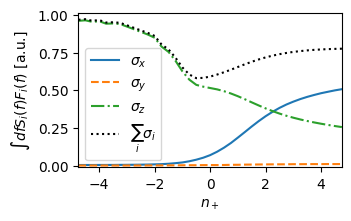

In [6]:
fig, ax = plt.subplots(figsize=(3.4, 2))

S = 1 / omegas
error = sp.integrate.trapezoid(S[None, None, :] * FF, omegas, axis=-1)

letters = [r'$\sigma_x$', r'$\sigma_y$', r'$\sigma_z$']
styles = ['-', '--', '-.']
for i in range(3):
    ax.plot(n_plus, error[:, i] / np.max(error), label=letters[i], ls=styles[i])

ax.plot(n_plus, np.sum(error, axis=1) / np.max(error), label=r'$\sum_i\sigma_i$', color='k', ls=':')
    
ax.set_ylabel(r'$\int df S_i(f) F_i(f)$ [a.u.]')
ax.legend()

ax.set_xlim(min(n_plus[1:-1]), max(n_plus[1:-1]))
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel(r'$n_+$');